我们要完成一次 Berlekamp 译码算法的仿真，参数如下：

- 信道类型：
    - 加性高斯白噪声 ( Additional Gaussian White Noise， AWGN )
- 调制方式：
    - BPSK
- 编码方式
    - RS ( 255, 239, 17 )
    - RS ( 255, 223, 33 )
    - Raw BPSK
- $E_b / N_0$
    - RS ( 255, 239, 17 ) : 4.0 ~ 7.5 dB
    - RS ( 255, 223, 33 ) : 4.0 ~ 7.0 dB 
- 仿真次数
    - 初始为 1e5 个块，以后每增加 1 dB 增加 10 倍。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import RS255

In [2]:
def EbN02Amp(EbN0db, N0, num_n, num_k):
    EbN0 = 10 ** (EbN0db / 10.0)
    Eb = EbN0 * N0
    return np.sqrt(2 * Eb / num_n * num_k)

为了保证 $Eb/N0$ 换算成星座映射的幅值是正确的，首先对BPSK的误码率进行仿真分析。

In [3]:
sim_psk_db = np.arange(0, 10.5, 0.5)
N0 = 1.0
amp = EbN02Amp(sim_psk_db, N0, 1, 1)
ber_psk = np.zeros(amp.shape)
bit_num = 10000000

for index, value in enumerate(amp):
    sequence_received = (np.random.randn(bit_num) * np.sqrt(N0) - value) > 0
    error_num = np.sum(sequence_received)
    ber_psk[index] = error_num / bit_num
    

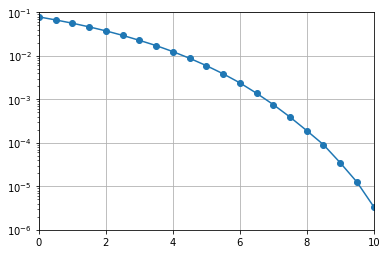

In [4]:
plt.semilogy(sim_psk_db, ber_psk, marker="o")
plt.grid(True)
plt.xlim(0, 10)
plt.ylim(1e-6, 1e-1)
plt.show()

可以看到误码率为 1e-5 的时，$E_b / N_0$ 大概为 9.6 dB。

之后对 RS(255, 255, 239, 17) 的误符号率和误块率进行统计。

In [89]:
db_255_239_17 = np.arange(4.4, 7.6, 0.2)
seq_num_255_239_17 = [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 50000, 100000, 800000]
amp = EbN02Amp(db_255_239_17, N0, 255, 239)
SER_255_239_17 = np.zeros(db_255_239_17.shape)
BLER_255_239_17 = np.zeros(db_255_239_17.shape)
for index, value in enumerate(amp):
    symbol_num = 0
    block_num = 0
    se_num = 0
    ble_num = 0
    print("db = ", db_255_239_17[index])
    for k in range(seq_num_255_239_17[index]):
        symbol_seq = np.zeros(255, dtype=np.uint16)
        rec_symbol_seq = np.zeros(255, dtype=np.uint16)
        bit_seq = np.random.randn(255 * 8) * np.sqrt(N0) - value
        for i in range(255):
            symbol = int(0)
            for j in range(8):
                symbol += (1 << j if bit_seq[i * 8 + j] > 0 else 0)
            symbol_seq[i] = symbol
        RS255.berlekamp_decoder(8, symbol_seq, rec_symbol_seq)
        symbol_error_flag = rec_symbol_seq > 0
        block_se_num = np.sum(symbol_error_flag[0:239])
        se_num += block_se_num
        ble_num += ( 1 if block_se_num > 0 else 0 )
        symbol_num += 255
        block_num += 1
        rec_error_num = np.sum(symbol_seq > 0)
        if block_se_num != 0 and rec_error_num <= 8:
            print("error")
    SER_255_239_17[index] = se_num / symbol_num
    BLER_255_239_17[index] = ble_num / block_num
    print("SER: ", SER_255_239_17[index])
    print("BLER: ", BLER_255_239_17[index])
    print()

db =  4.4
SER:  0.08776470588235294
BLER:  1.0

db =  4.6000000000000005
SER:  0.07454901960784313
BLER:  1.0

db =  4.800000000000001
SER:  0.06513725490196079
BLER:  0.95

db =  5.000000000000001
SER:  0.058
BLER:  0.95

db =  5.200000000000001
SER:  0.04749019607843137
BLER:  0.85

db =  5.400000000000001
SER:  0.036588235294117644
BLER:  0.77

db =  5.600000000000001
SER:  0.024705882352941175
BLER:  0.54

db =  5.800000000000002
SER:  0.016431372549019607
BLER:  0.39

db =  6.000000000000002
SER:  0.006941176470588235
BLER:  0.17

db =  6.200000000000002
SER:  0.003156862745098039
BLER:  0.085

db =  6.400000000000002
SER:  0.0012019607843137255
BLER:  0.031

db =  6.600000000000002
SER:  0.00031764705882352944
BLER:  0.008

db =  6.8000000000000025
SER:  6.823529411764705e-05
BLER:  0.0018

db =  7.000000000000003
SER:  2.0549019607843136e-05
BLER:  0.00056

db =  7.200000000000003
SER:  2.1568627450980393e-06
BLER:  6e-05

db =  7.400000000000003
SER:  3.480392156862745e-07
BLER

得到的仿真曲线如下：

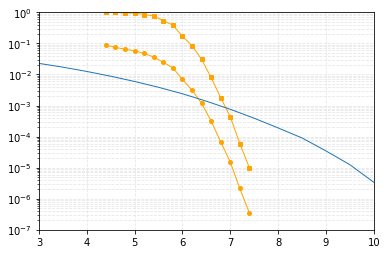

In [122]:
plt.semilogy(db_255_239_17,
                    SER_255_239_17,
                    marker="o",
                    color="orange",
                    markersize=4,
                    lw=1)
plt.semilogy(db_255_239_17,
                    BLER_255_239_17,
                    marker="s",
                    color="orange",
                    markersize=4,
                    lw=1)
plt.semilogy(sim_psk_db, ber_psk, lw=1)
plt.grid(True, which="both", color='0.9', ls="--")
plt.xlim(3, 10.0)
plt.ylim(1e-7, 1)
plt.show()

之后对 RS(255, 223, 33) 的误符号率和误块率进行统计。

In [93]:
db_255_223_33 = np.arange(4.4, 6.8, 0.2)
seq_num_255_223_33 = [20000, 20000, 20000, 20000, 20000, 20000, 20000, 20000, 20000, 20000, 200000, 800000]
amp = EbN02Amp(db_255_223_33, N0, 255, 223)
SER_255_223_33 = np.zeros(db_255_223_33.shape)
BLER_255_223_33 = np.zeros(db_255_223_33.shape)
for index, value in enumerate(amp):
    symbol_num = 0
    block_num = 0
    se_num = 0
    ble_num = 0
    seq_num = 100 * 10 ** ( int(db_255_223_33[index] - 4.0) )
    print("db = ", db_255_223_33[index])
    for k in range(seq_num_255_223_33[index]):
        symbol_seq = np.zeros(255, dtype=np.uint16)
        rec_symbol_seq = np.zeros(255, dtype=np.uint16)
        bit_seq = np.random.randn(255 * 8) * np.sqrt(N0) - value
        for i in range(255):
            symbol = int(0)
            for j in range(8):
                symbol += (1 << j if bit_seq[i * 8 + j] > 0 else 0)
            symbol_seq[i] = symbol
        RS255.berlekamp_decoder(16, symbol_seq, rec_symbol_seq)
        symbol_error_flag = rec_symbol_seq > 0
        block_se_num = np.sum(symbol_error_flag[0:223])
        se_num += block_se_num
        ble_num += ( 1 if block_se_num > 0 else 0 )
        symbol_num += 255
        block_num += 1
        rec_error_num = np.sum(symbol_seq > 0)
        if block_se_num != 0 and rec_error_num <= 16:
            print("error")
    SER_255_223_33[index] = se_num / symbol_num
    BLER_255_223_33[index] = ble_num / block_num
    print("SER: ", SER_255_223_33[index])
    print("BLER: ", BLER_255_223_33[index])
    print()

db =  4.4
SER:  0.09654901960784314
BLER:  0.98

db =  4.6000000000000005
SER:  0.08168627450980392
BLER:  0.95

db =  4.800000000000001
SER:  0.06133333333333333
BLER:  0.77

db =  5.000000000000001
SER:  0.04827450980392157
BLER:  0.65

db =  5.200000000000001
SER:  0.03050980392156863
BLER:  0.43

db =  5.400000000000001
SER:  0.015267973856209151
BLER:  0.22666666666666666

db =  5.600000000000001
SER:  0.0045
BLER:  0.06625

db =  5.800000000000002
SER:  0.001780392156862745
BLER:  0.027

db =  6.000000000000002
SER:  0.00033490196078431373
BLER:  0.0054

db =  6.200000000000002
SER:  4.862745098039216e-05
BLER:  0.00075

db =  6.400000000000002
SER:  6.058823529411764e-06
BLER:  9.5e-05

db =  6.600000000000002
SER:  2.941176470588235e-07
BLER:  5e-06



得到的仿真曲线如下：

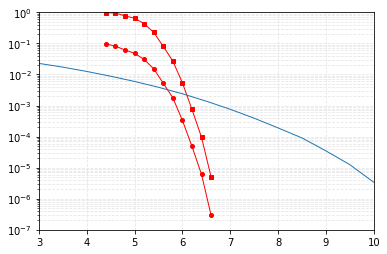

In [121]:
plt.semilogy(db_255_223_33,
                    SER_255_223_33,
                    marker="o",
                    color="r",
                    markersize=4,
                    lw=1)
plt.semilogy(db_255_223_33,
                    BLER_255_223_33,
                    marker="s",
                    color="r",
                    markersize=4,
                    lw=1)
plt.semilogy(sim_psk_db, ber_psk, lw=1)
plt.grid(True, which="both", color='0.9', ls="--")
plt.xlim(3, 10.0)
plt.ylim(1e-7, 1)
plt.show() 

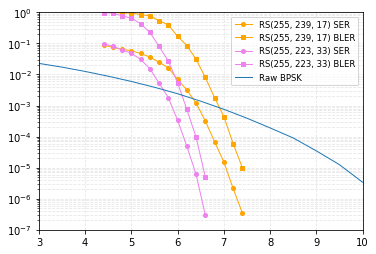

In [120]:
plt.figure(figsize = (5.8, 4))
f1, = plt.semilogy(db_255_239_17,
                            SER_255_239_17,
                            marker="o",
                            color="orange",
                            markersize=4,
                            lw=1)
f2, = plt.semilogy(db_255_239_17,
                            BLER_255_239_17,
                            marker="s",
                            color="orange",
                            markersize=4,
                            lw=1)
f3, = plt.semilogy(db_255_223_33,
                            SER_255_223_33,
                            marker="o",
                            color="violet",
                            markersize=4,
                            lw=1, 
                            label="RS(255, 223, 33) SER")
f4, = plt.semilogy(db_255_223_33,
                            BLER_255_223_33,
                            marker="s",
                            color="violet",
                            markersize=4,
                            lw=1)
f5, = plt.semilogy(sim_psk_db, ber_psk, lw=1)
plt.legend(handles= [f1, f2, f3, f4, f5], 
                 labels = [
                     "RS(255, 239, 17) SER",
                     "RS(255, 239, 17) BLER",
                     "RS(255, 223, 33) SER",
                     "RS(255, 223, 33) BLER", 
                     "Raw BPSK"],
                 loc='best',
                 prop={'size': 8.5})
plt.grid(True, which="both", color='0.9', ls="--")
plt.xlim(3, 10.0)
plt.ylim(1e-7, 1)
plt.show() 

In [131]:
import scipy.io as sio
sio.savemat('RS_255_239_17.mat', {'dB': db_255_239_17,'BLER': SER_255_239_17,'SER': SER_255_239_17})
sio.savemat('RS_255_223_33.mat', {'dB': db_255_223_33,'BLER': SER_255_223_33,'SER': SER_255_223_33})

In [132]:
a = sio.loadmat("RS_255_239_17.mat")
b = sio.loadmat("RS_255_223_33.mat")

In [130]:
a

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Tue Jul 17 12:47:18 2018',
 '__version__': '1.0',
 '__globals__': [],
 'dB': array([[4.4, 4.6, 4.8, 5. , 5.2, 5.4, 5.6, 5.8, 6. , 6.2, 6.4, 6.6, 6.8,
         7. , 7.2, 7.4]]),
 'BLER': array([[8.77647059e-02, 7.45490196e-02, 6.51372549e-02, 5.80000000e-02,
         4.74901961e-02, 3.65882353e-02, 2.47058824e-02, 1.64313725e-02,
         6.94117647e-03, 3.15686275e-03, 1.20196078e-03, 3.17647059e-04,
         6.82352941e-05, 1.52941176e-05, 2.15686275e-06, 3.48039216e-07]]),
 'SER': array([[8.77647059e-02, 7.45490196e-02, 6.51372549e-02, 5.80000000e-02,
         4.74901961e-02, 3.65882353e-02, 2.47058824e-02, 1.64313725e-02,
         6.94117647e-03, 3.15686275e-03, 1.20196078e-03, 3.17647059e-04,
         6.82352941e-05, 1.52941176e-05, 2.15686275e-06, 3.48039216e-07]])}

In [133]:
b

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Tue Jul 17 12:48:53 2018',
 '__version__': '1.0',
 '__globals__': [],
 'dB': array([[4.4, 4.6, 4.8, 5. , 5.2, 5.4, 5.6, 5.8, 6. , 6.2, 6.4, 6.6]]),
 'BLER': array([[9.65490196e-02, 8.16862745e-02, 6.13333333e-02, 4.82745098e-02,
         3.05098039e-02, 1.52679739e-02, 5.24862745e-03, 1.78039216e-03,
         3.34901961e-04, 4.86274510e-05, 6.05882353e-06, 2.94117647e-07]]),
 'SER': array([[9.65490196e-02, 8.16862745e-02, 6.13333333e-02, 4.82745098e-02,
         3.05098039e-02, 1.52679739e-02, 5.24862745e-03, 1.78039216e-03,
         3.34901961e-04, 4.86274510e-05, 6.05882353e-06, 2.94117647e-07]])}